Ширина спектра: 48.69468613064179


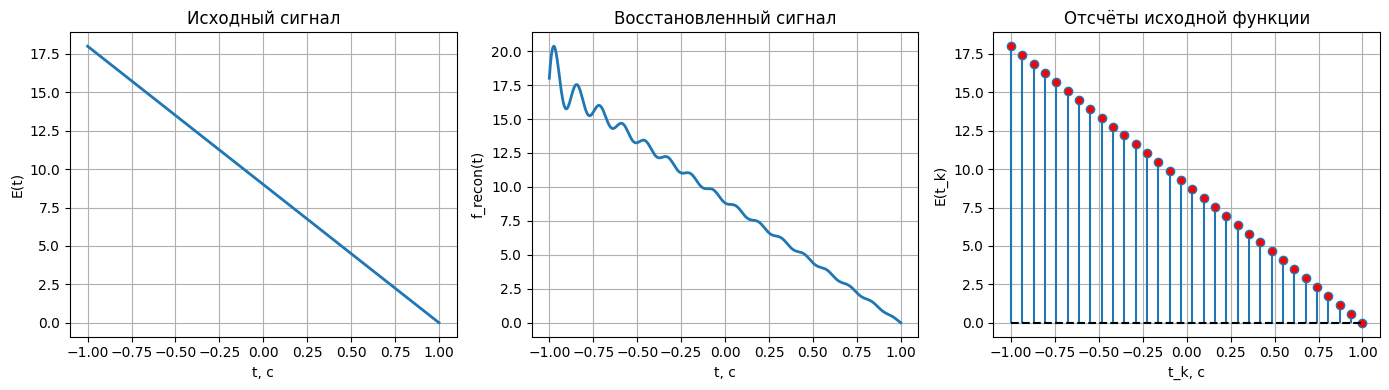

In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Новые параметры
E_max = 18.0    # максимальное значение сигнала
t_i = 2.0       # длительность импульса
T = t_i         # интервал определения функции: от -T/2 до T/2

N = 1000  # число точек для численного интегрирования

# Новая функция с заданной формой "прямоугольного треугольника"
def Func(t):
    # Функция определена на отрезке [-T/2, T/2]
    if t < -T/2 or t > T/2:
        return 0.0
    # В точке -T/2 задаем значение E_max (имитируя вертикальный скачок)
    elif math.isclose(t, -T/2, rel_tol=1e-12, abs_tol=1e-12):
        return E_max
    else:
        # Линейное убывание от E_max до 0
        return E_max * (1 - ((t + T/2) / T))

# Функция для численного расчёта энергии сигнала
def signal_energy():
    a = -T/2
    b = T/2
    h = (b - a) / N
    E = 0.0
    for i in range(N + 1):
        x = a + i * h
        val = Func(x) ** 2
        if i == 0 or i == N:
            E += val
        else:
            E += 2 * val
    E *= (h / 2.0)
    return E

# Вычисление действительной составляющей Фурье-образа
def Real_calculate(w):
    a = -T/2
    b = T/2
    h = (b - a) / N
    result = 0.0
    for i in range(N + 1):
        x = a + i * h
        val = Func(x) * math.cos(w * x)
        if i == 0 or i == N:
            result += val
        else:
            result += 2 * val
    return result * (h / 2.0)

# Вычисление мнимой составляющей Фурье-образа
def Imag_calculate(w):
    a = -T/2
    b = T/2
    h = (b - a) / N
    result = 0.0
    for i in range(N + 1):
        x = a + i * h
        val = Func(x) * math.sin(w * x)
        if i == 0 or i == N:
            result += val
        else:
            result += 2 * val
    return result * (h / 2.0)

# Спектральная плотность (модуль Фурье-образа)
def S_w_calculate(w):
    real = Real_calculate(w)
    imag = Imag_calculate(w)
    return math.sqrt(real * real + imag * imag)

# Интегрирование спектральной энергии по частоте до w
def E_w_calculate(w, E):
    a = 0.0
    b = w
    steps = 1000
    h = (b - a) / steps
    integral = 0.0
    for i in range(steps + 1):
        w_i = a + i * h
        val = (S_w_calculate(w_i) ** 2)
        if i == 0 or i == steps:
            integral += val
        else:
            integral += 2 * val
    integral *= (h / 2.0) * (1.0 / math.pi)
    return integral

# Расчёт энергии сигнала
E = signal_energy()

# Поиск "ширины спектра" w_final, при котором накопленная спектральная энергия достигает 99% от полной энергии
w_start = math.pi / T
w_final = 0.0
for num in range(1, 101):
    w_k = w_start * num
    E_w = E_w_calculate(w_k, E)
    if (abs(E_w - E) / E) * 100 < 1:
        w_final = w_k
        break

print("Ширина спектра:", w_final)

# Построение графиков

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# График 1. Исходный сигнал (на отрезке [-T/2, T/2])
t_vals = np.linspace(-T/2, T/2, 1000)
f_vals = [Func(tv) for tv in t_vals]
axes[0].plot(t_vals, f_vals, lw=2)
axes[0].set_title("Исходный сигнал")
axes[0].set_xlabel("t, с")
axes[0].set_ylabel("E(t)")
axes[0].grid(True)

# Если w_final не найдено, используем значение по умолчанию
if w_final == 0:
    w_final = w_start
# Определение шага дискретизации по времени по теореме о сэмплировании:
delta_t = math.pi / w_final if w_final != 0 else T / 10
if delta_t <= 0:
    delta_t = T / 10

# Определим набор отсчетов равномерно на отрезке [-T/2, T/2]
k_max = int(T / delta_t)
t_points = [ -T/2 + k * delta_t for k in range(k_max + 1) ]
f_points = [ Func(tp) for tp in t_points ]

# Реконструкция сигнала методом sinc-интерполяции (на том же интервале)
t_recon = np.linspace(-T/2, T/2, 1000)
recon_vals = []
for tr in t_recon:
    val = 0.0
    for t_k, f_k in zip(t_points, f_points):
        denom = w_final * (tr - t_k)
        if math.isclose(tr, t_k, rel_tol=1e-14):
            val += f_k
        else:
            # Если знаменатель не равен нулю, используем функцию sinc (без нормирования np.sinc)
            val += f_k * (math.sin(denom) / denom)
    recon_vals.append(val)

axes[1].plot(t_recon, recon_vals, lw=2)
axes[1].set_title("Восстановленный сигнал")
axes[1].set_xlabel("t, с")
axes[1].set_ylabel("f_recon(t)")
axes[1].grid(True)

# График 3. Отсчёты исходной функции
markerline, stemlines, baseline = axes[2].stem(t_points, f_points, basefmt="k--")
plt.setp(markerline, 'markerfacecolor', 'red')
axes[2].set_title("Отсчёты исходной функции")
axes[2].set_xlabel("t_k, с")
axes[2].set_ylabel("E(t_k)")
axes[2].grid(True)

plt.tight_layout()
plt.show()
